* 整理自链接： https://hrl.boyuai.com/chapter/2/%E7%AD%96%E7%95%A5%E6%A2%AF%E5%BA%A6%E7%AE%97%E6%B3%95

——————

- [ ] 没有考虑随机种子的影响
- [ ] 没有存储训练好的网络权重
- [ ] 没有在 环境中 试运行策略

——————

REINFORCE 算法理论上是能保证局部最优的，它实际上是借助**蒙特卡洛方法**采样轨迹来**估计动作价值**，这种做法的一大优点是可以得到**无偏的梯度**。但是，正是因为使用了蒙特卡洛方法，REINFORCE 算法的梯度估计的<font color=red>**方差很大**</font>，可能会造成一定程度上的不稳定，这也是第 10 章将介绍的 Actor-Critic 算法要解决的问题。

## 代码模块

In [ ]:
!pip install gymnasium

In [ ]:
import gymnasium as gym
import torch
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
# import rl_utils

# https://github.com/boyu-ai/Hands-on-RL/blob/main/rl_utils.py


### 策略网络

输入： 某个状态

输出： 该状态下的动作概率分布

In [ ]:
class PolicyNet(torch.nn.Module):
  def __init__(self, state_dim, hidden_dim, action_dim):
    super(PolicyNet, self).__init__()
    self.fc1 = torch.nn.Linear(state_dim, hidden_dim)
    self.fc2 = torch.nn.Linear(hidden_dim, action_dim)

  def forward(self, x):
    x = F.relu(self.fc1(x))
    return F.softmax(self.fc2(x), dim=1)

### REINFORCE 算法

In [ ]:
class REINFORCE:
  def __init__(self, state_dim, hidden_dim, action_dim, learning_rate, gamma, device):
    self.policy_net = PolicyNet(state_dim, hidden_dim, action_dim).to(device)
    self.optimizer = torch.optim.Adam(self.policy_net.parameters(),lr=learning_rate) # 优化器
    self.gamma = gamma #折扣因子
    self.device = device

  def take_action(self, state): #
    state = torch.tensor([state], dtype=torch.float).to(self.device)
    probs = self.policy_net(state)
    action = torch.distributions.Categorical(probs).sample().item()
    return action

  def update(self, transition_dict): # 每回合 更新一次
    reward_list = transition_dict['rewards']
    state_list = transition_dict['states']
    action_list = transition_dict['actions']


    G = 0  # 回报
    self.optimizer.zero_grad() # 梯度重置
    for i in reversed(range(len(reward_list))): # T-1, T-2,...,0  时间步
      reward = reward_list[i]
      state = torch.tensor([state_list[i]], dtype=torch.float).to(self.device)
      action = torch.tensor([action_list[i]]).view(-1,1).to(self.device)  # .view(-1,1) 将张量重新塑造为一个列数为 1，行数自动推断的二维张量。
      log_prob = torch.log(self.policy_net(state).gather(1,action))  # 默认是以 e 为底的   # Tensor.gather(dim, index) → Tensor
      G = self.gamma * G + reward  # G←γG + r_{t+1}
      loss = -log_prob * G
      loss.backward()  # 反向传播
    self.optimizer.step()   # 更新


## 训练


环境链接： https://gymnasium.farama.org/environments/classic_control/cart_pole/

In [ ]:
learning_rate = 1e-3
num_episodes = 1000   # 1000  ## 限定了回合数 6000 估计可以得到较稳定的结果
hidden_dim = 128
gamma = 0.98
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

env_name = 'CartPole-v1'
env = gym.make(env_name, render_mode='rgb_array')
torch.manual_seed(0)
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.n

# 代理
agent = REINFORCE(state_dim, hidden_dim, action_dim, learning_rate, gamma, device)

return_list = []
for i in range(10):  # 一共显示 10 个进度条，每个进度条的回合数为全部回合数的均分
  with tqdm(total=int(num_episodes / 10), desc='Iteration %d' % i) as pbar:
    for i_episode in range(int(num_episodes / 10)):
      episode_return = 0
      transition_dict = {
          'states': [],
          'actions': [],
          'next_states': [],
          'rewards': [],
          'dones': []
      }

      state = env.reset(seed=42)[0]
      done = False
      while not done:
        action = agent.take_action(state)
        next_state, reward, terminated, truncated, info = env.step(action)
        done = terminated or truncated
        transition_dict['states'].append(state)
        transition_dict['actions'].append(action)
        transition_dict['next_states'].append(next_state)
        transition_dict['rewards'].append(reward)
        transition_dict["dones"].append(done)
        state = next_state
        episode_return += reward
      return_list.append(episode_return)
      agent.update(transition_dict)  # T 个时间步的 transition 信息用于更新 网络的权重
      if (i_episode + 1) % 10 == 0:
        pbar.set_postfix({
          'episode': '%d' % (num_episodes / 10 * i + i_episode + 1),
          'return': '%.3f' % np.mean(return_list[-10:])
        })  # 显示的回报是 后 10 个回合的平均

      pbar.update(1)


# 'CartPole-v1' 的奖励阈值为 500

Iteration 9: 100%|██████████| 100/100 [00:41<00:00,  2.38it/s, episode=1000, return=400.800]


## 可视化

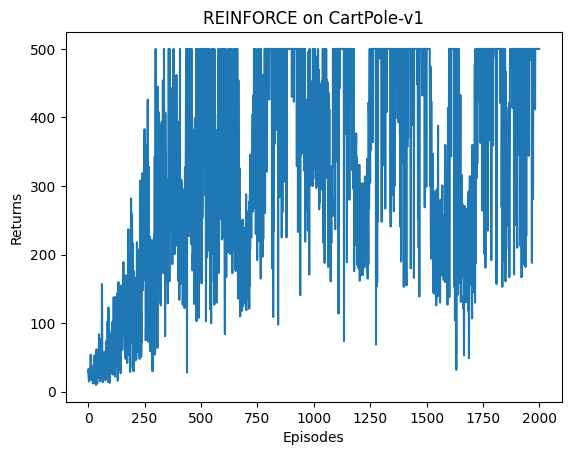

In [ ]:
episodes_list = list(range(len(return_list)))
plt.plot(episodes_list, return_list)  # x y
plt.xlabel('Episodes')
plt.ylabel('Returns')
plt.title('REINFORCE on {}'.format(env_name))
plt.show()

<mark><font size=5>**方差大，预测结果不稳定！！！**</font></mark>

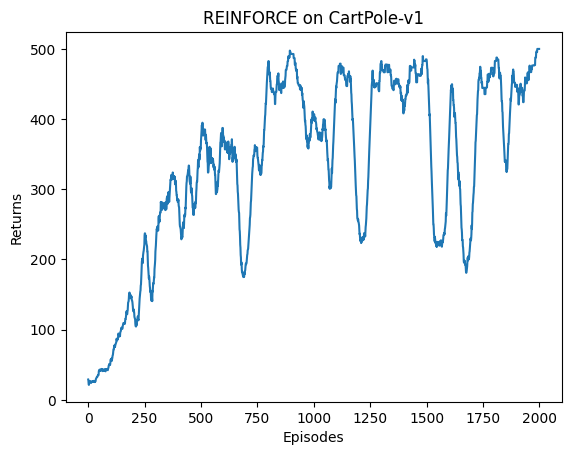

In [ ]:
# 平滑

def moving_average(a, window_size):
    cumulative_sum = np.cumsum(np.insert(a, 0, 0))
    middle = (cumulative_sum[window_size:] - cumulative_sum[:-window_size]) / window_size
    r = np.arange(1, window_size-1, 2)
    begin = np.cumsum(a[:window_size-1])[::2] / r
    end = (np.cumsum(a[:-window_size:-1])[::2] / r)[::-1]
    return np.concatenate((begin, middle, end))

mv_return = moving_average(return_list, 29)  # 9 可考虑改大些，让图好看些
plt.plot(episodes_list, mv_return)  # x y
plt.xlabel('Episodes')
plt.ylabel('Returns')
plt.title('REINFORCE on {}'.format(env_name))
plt.show()


### 一些训练结果

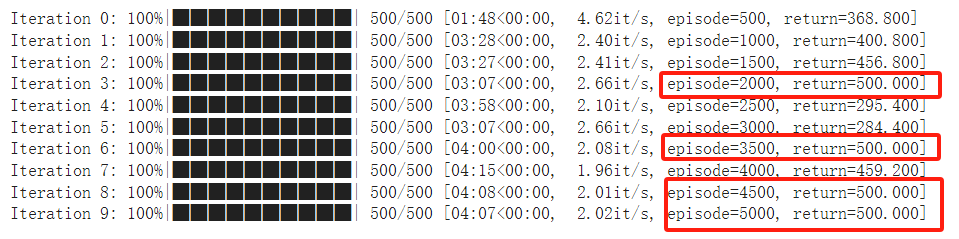

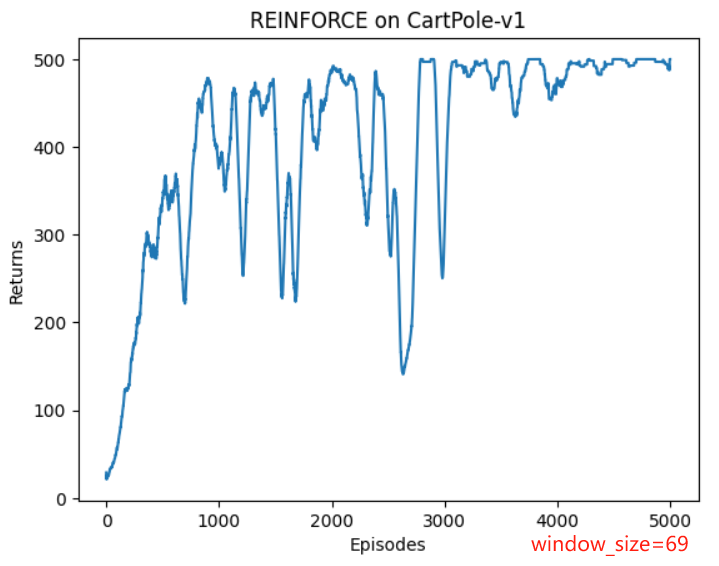